# Random Forest Project

In [1]:
from dotenv import load_dotenv
import os, sys
import pandas as pd
import numpy as np
from sqlmodel import Session
from typing import Tuple
import gc

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))  
from services.house import HouseService
from models.user_input import UserInput
from models.house import House
from db import engine, db_session

load_dotenv()

db_url = os.getenv("DATABASE_URL")

# User Inputs to the Model 
### For the population question: 
#### House dataset
- Small: 0 - 672508, 
- Medium: 672509 - 1452726, 
- Large: >= 1452727 

#### Housing Data 2 dataset
- Small: 0 - 25556, 
- Medium: 25557 - 115264, 
- Large: >= 115265 

### For all other questions, we will attempt to matchmake you to answers close to yours with pinpoint accuracy

In [2]:
# Define user inputs here
user_desired_home_price = input("What is your target home price? (e.g. 345000)")
user_income = input("What is your income? (e.g. 123000)")
user_beds = input("How many bedrooms would you like your home to have? (e.g. 3)")
user_baths = input("How many bathrooms would you like your home to have? (e.g. 2)")
user_area = input("Do you have an ideal square footage in mind? (e.g. 1350)")
user_population = input("What size of a city would you like to live in? (e.g. Small, Medium, Large)")

# Transforming Database Tables Into Dataframes

In [3]:
with Session(engine) as session:
        house_svc = HouseService(session)
        house_data_df = house_svc.get_house_data_df()
        housing_data_df = house_svc.get_housing_data2_df()
        print("Via Session(engine):")
        print(house_data_df.head(), housing_data_df.head(), sep="\n")

2025-04-24 05:42:16,778 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-04-24 05:42:16,780 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-24 05:42:16,841 INFO sqlalchemy.engine.Engine select current_schema()
2025-04-24 05:42:16,842 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-24 05:42:16,909 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-04-24 05:42:16,910 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-24 05:42:16,970 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-24 05:42:16,976 INFO sqlalchemy.engine.Engine SELECT "House".id, "House"."State", "House"."City", "House"."Bedroom", "House"."Bathroom", "House"."Area", "House"."ListedPrice", "House"."Temperature", "House"."2022 Population", "House"."2016 Crime Rate", "House"."Unemployment", "House"."AQI%%Good", "House"."WaterQualityVPV", "House"."Cost of Living", "House"."AVG C2I", "House"."MeanIncome", "House"."QualityOfLifeTotalScore", "House"."QualityOfLifeQualityOfLife", "House".


# Now we need to create the Random Forest Model, Input the 2 dataframes, and then output results

In [4]:
# Group the populations by quantile and save to CSVs
house_data_df["population_category"] = house_svc.categorize_pop_by_quantile(house_data_df["population"])
housing_data_df["population_category"] = house_svc.categorize_pop_by_quantile(housing_data_df["population"])
house_svc.save_house_data_to_csvs(house_data=house_data_df, housing_data=housing_data_df)

House data saved to ../data/house_data.csv
House data saved to ../data/housing_data2.csv


In [5]:
user_input = UserInput(
    desired_home_price=int(user_desired_home_price),
    income=int(user_income),
    bedroom=int(user_beds),
    bathroom=int(user_baths),
    area=int(user_area),
    population=user_population.strip().lower()
    )

W = dict(price=.4, beds=.2, baths=.1, area=.1, pop=.2)

def make_target(df: pd.DataFrame, u: UserInput) -> pd.Series:
    rel = lambda col,val: 1 - np.minimum(np.abs(df[col]-val)/max(val,1), 1)
    t   = W['price']*rel('listed_price', u.desired_home_price)\
        + W['beds'] *rel('bedroom',      u.bedroom)\
        + W['baths']*rel('bathroom',     u.bathroom)\
        + W['area'] *rel('area',         u.area)\
        + W['pop']  *(df['population']==u.population).astype(float)
    return t

# ----- weights you like
W_HOUSE = dict(price=.35, beds=.2, baths=.15, area=.15, pop=.15, qol=.0)
W_QOL   = dict(qol_total=.6, qol_aff=.1, qol_econ=.1, qol_ed=.1, qol_safe=.1)

# ========= builder that works for HOUSE_DATA.CSV =========
def target_house(df: pd.DataFrame, user: UserInput):
    rel = lambda col,val: 1 - np.minimum(np.abs(df[col]-val)/max(val,1), 1)
    score = ( W_HOUSE['price']*rel('listed_price', user.desired_home_price)
            + W_HOUSE['beds'] *rel('bedroom',      user.bedroom)
            + W_HOUSE['baths']*rel('bathroom',     user.bathroom)
            + W_HOUSE['area'] *rel('area',         user.area)
            + W_HOUSE['pop']  *(df['population']==user.population).astype(float)
            # add QoL if you want:
            + W_HOUSE['qol']  *(
                  (df['quality_of_life_total_score']-df['quality_of_life_total_score'].min())
                 /(df['quality_of_life_total_score'].max()-df['quality_of_life_total_score'].min())
              )
           )
    return score

W_ECON = dict(cost=.3, crime=.25, aqi=.25, unem=.2)

def target_housing2(df: pd.DataFrame, _user=None):
    z = lambda col: (df[col]-df[col].min())/(df[col].max()-df[col].min())
    return ( W_ECON['cost']  * (1 - z('cost_of_living')) +   # lower cost better
             W_ECON['crime'] * (1 - z('crime_rate'))     +   # lower crime better
             W_ECON['aqi']   * z('aqi_good')             +   # higher good-AQI better
             W_ECON['unem']  * (1 - z('unemployment')) )     # lower unemployment better

def train_rf_and_rank(df: pd.DataFrame,
                      user: UserInput,
                      target_builder,
                      test_frac: float = 0.8,
                      rng: int = 42,
                      n_estimators: int = 80,
                      max_depth: int = 12,
                      top_n: int = 5):
    """Return (pipeline, metrics_dict, topN_df)."""

    # -------------------------------------------------
    # 0)   build target column for THIS user
    # -------------------------------------------------
    df = df.copy()
    df['target'] = target_builder(df, user) 
    df = df.dropna(subset=['target']).reset_index(drop=True)
    X = df.drop(columns=['target'])
    y = df['target']

    # -------------------------------------------------
    # 1)   20 % train / 80 % test
    # -------------------------------------------------
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        train_size=1-test_frac,
        test_size=test_frac,
        random_state=rng
    )

    num_cols = X_tr.select_dtypes(include='number').columns.tolist()
    cat_cols = [c for c in X_tr.columns if c not in num_cols]

    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sca', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1))
    ])
    pre = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

    rf = Pipeline([
        ('pre', pre),
        ('rf',  RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    random_state=rng,
                    n_jobs=1))                 # 1 core → low RAM
    ])

    rf.fit(X_tr, y_tr)

    # -------------------------------------------------
    # 2)   metrics on held-out set
    # -------------------------------------------------
    pred = rf.predict(X_te)
    metrics = dict(
        RMSE = mean_squared_error(y_te, pred),
        MAE  = mean_absolute_error(y_te, pred),
        MAPE = np.mean(np.abs((y_te - pred)/np.maximum(1e-12, y_te))),
        R2   = r2_score(y_te, pred)
    )

    # -------------------------------------------------
    # 3)   rank every city for THIS user
    # -------------------------------------------------
    df['rf_score'] = rf.predict(X)
    top = (df.groupby(['state','city'])['rf_score']
             .mean().reset_index()
             .sort_values('rf_score', ascending=False)
             .head(top_n))

    return rf, metrics, top

# Results from the House Dataset

In [6]:
house_pipeline, house_loss, house_top5 = train_rf_and_rank(
    house_data_df, user_input, target_builder=target_house, test_frac=0.8, top_n=5)

print("Loss / accuracy metrics on 80 % hold-out:")
for k,v in house_loss.items():
    print(f"{k:5}: {v:.4f}")

print("\nTop-5 recommended cities:")
print(house_top5)

housing_pipeline, housing_loss, housing_top5 = train_rf_and_rank(
    housing_data_df, user_input, target_builder=target_housing2, test_frac=0.8, top_n=5)

print("Loss / accuracy metrics on 80 % hold-out:")
for k,v in housing_loss.items():
    print(f"{k:5}: {v:.4f}")

print("\nTop-5 recommended cities:")
print(housing_top5)


Loss / accuracy metrics on 80 % hold-out:
RMSE : 0.0002
MAE  : 0.0071
MAPE : 1848349.5156
R2   : 0.9905

Top-5 recommended cities:
    state                 city  rf_score
62     id             boise,id  0.553254
29     co  colorado springs,co  0.549911
196    vt        burlington,vt  0.544951
26     ca       santa maria,ca  0.544414
1      ak            bethel,ak  0.535130
Loss / accuracy metrics on 80 % hold-out:
RMSE : 0.0000
MAE  : 0.0012
MAPE : 0.0016
R2   : 0.9994

Top-5 recommended cities:
     state        city  rf_score
5299    nd  lamoure,nd  0.950561
5257    nd  edgeley,nd  0.950525
5250    nd   crosby,nd  0.950489
5233    nd    beach,nd  0.950349
5297    nd     kulm,nd  0.950141


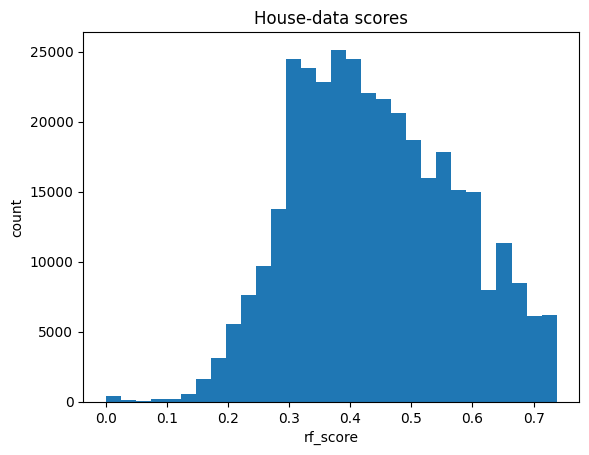

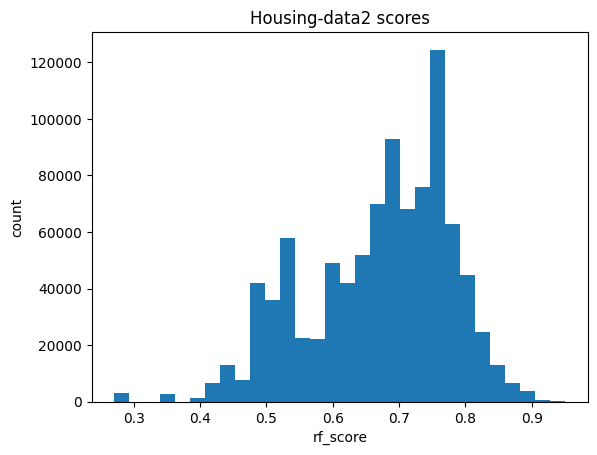

In [7]:
# give the model the full frame (minus target), not a pruned one
X_house_full = house_data_df.copy()        # it never had 'target'
house_scores = house_pipeline.predict(X_house_full)

plt.hist(house_scores, bins=30)
plt.xlabel('rf_score'); plt.ylabel('count'); plt.title('House-data scores')
plt.show()

# use *housing_pipeline* for housing_data_df
X_housing_full = housing_data_df.copy()
housing_scores = housing_pipeline.predict(X_housing_full)

plt.hist(housing_scores, bins=30)
plt.xlabel('rf_score'); plt.ylabel('count'); plt.title('Housing-data2 scores')
plt.show()
